Download the Tatoeba Sentences dataset into the data/tatoeba/ directory to begin: https://downloads.tatoeba.org/exports/sentences.tar.bz2

In [ ]:
# don't touch it if it works. I disclaim any warranties, expressed or implied.
%pip install scikit-learn
%pip install pandas
%pip install numpy
%pip install tqdm
%pip install --upgrade jupyter ipywidgets
%pip install jupyter_contrib_nbextensions
%pip install umap-learn
%pip install matplotlib
!jupyter contrib nbextension install --user
!jupyter nbextension enable varInspector/main


In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.notebook import tqdm
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.cluster import KMeans
import scipy.sparse as sp

In [3]:
# Load the dataset
df = pd.read_csv('data/tatoeba/sentences.csv', sep='\t', header=None, names=['id', 'lang', 'sentence'])
# drop rows containing a nan
df = df.dropna()

print(df.head())

   id lang                sentence
0   1  cmn                  我們試試看！
1   2  cmn                 我该去睡觉了。
2   3  cmn                 你在干什麼啊？
3   4  cmn                  這是什麼啊？
4   5  cmn  今天是６月１８号，也是Muiriel的生日！


In [4]:

print("Vectorizing sentences...")
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 4), min_df=0.01)
X = vectorizer.fit_transform(tqdm(df['sentence'], desc='Vectorizing sentences'))


Vectorizing sentences...


Vectorizing sentences:   0%|          | 0/11879690 [00:00<?, ?it/s]

In [5]:
sp.save_npz('data/tatoeba/tfidf_matrix.npz', X)

In [6]:

print("Averaging vectors...")
# Group by language and average the vectors without converting to dense array all at once
# Initialize a dictionary to store partial sums and counts for each language
partial_sums = {lang: np.zeros(X.get_shape()[1]) for lang in df['lang'].unique()}
counts = {lang: 0 for lang in df['lang'].unique()}

batch_size = 1000
for start_idx in tqdm(range(0, len(df), batch_size), desc='Processing in batches'):
    end_idx = min(start_idx + batch_size, len(df))
    batch_df = df.iloc[start_idx:end_idx]
    batch_X = X[start_idx:end_idx]

    for lang, group in batch_df.groupby('lang'):
        group_indices = [batch_df.index.get_loc(idx) for idx in group.index]  # Adjust indices for the current batch
        # print(f"Group language: {lang}, Start index: {start_idx}, Group indices: {group_indices}")  # Debug print

        try:
            group_vectors = batch_X[group_indices]
        except IndexError as e:
            print(f"Error for language {lang} in batch starting at {start_idx}: {e}")
            print(f"Group indices: {group_indices}")
            raise e  # Reraise the exception to stop the loop and inspect the problem

        # Use sparse matrix operations to sum vectors
        if isinstance(group_vectors, list):
            group_vectors = sp.vstack(group_vectors)  # Convert list of sparse matrices to a single sparse matrix

        partial_sums[lang] += group_vectors.sum(axis=0).A1
        counts[lang] += group_vectors.shape[0]



# Compute the final averages
language_vectors = {lang: partial_sums[lang] / counts[lang] for lang in partial_sums}

print("Converting into a matrix...")
# Convert the averaged vectors to a matrix
language_matrix = np.vstack(list(language_vectors.values()))

# label with the language
language_labels = list(language_vectors.keys())

# save to files
np.save('data/tatoeba/language_matrix.npy', language_matrix)
np.save('data/tatoeba/language_labels.npy', language_labels)


Averaging vectors...


Processing in batches:   0%|          | 0/11880 [00:00<?, ?it/s]

Converting into a matrix...


Clustering...


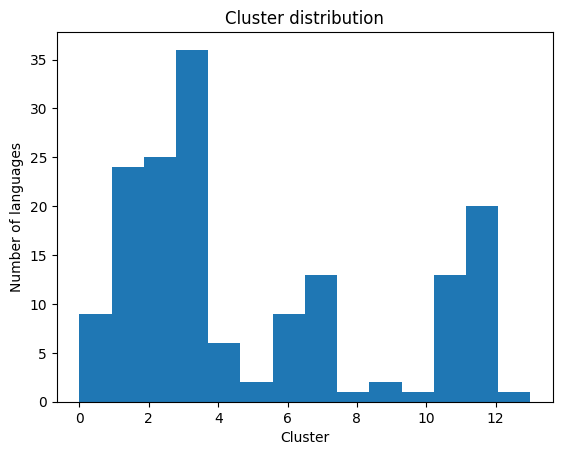

In [89]:

import matplotlib.pyplot as plt
import umap

language_matrix = np.load('data/tatoeba/language_matrix.npy')
language_labels = np.load('data/tatoeba/language_labels.npy')
# drop the rows with labels corresponding to the languages that are have fewer than 100 sentences
# this is every language 231 and beyond
# 500 is 162
language_labels = language_labels[:162]
language_matrix = language_matrix[:162]

# load the language codes
language_codes = pd.read_csv('data/tatoeba/lang_to_language.csv', header=None, names=['code', 'language'])
language_codes = language_codes.set_index('code')

# convert the language codes into the full language
# data from https://tatoeba.org/en/stats/sentences_by_language
lang_labels = language_labels
language_labels = language_codes.loc[lang_labels]['language']

print("Clustering...")
# Cluster the language matrix
n_clusters = 14
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(language_matrix)

plt.hist(cluster_labels, bins=n_clusters)
plt.title('Cluster distribution')
plt.xlabel('Cluster')
plt.ylabel('Number of languages')
plt.show()


umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine')
umap_embedding = umap_model.fit_transform(language_matrix)

# save umap_embedding
# np.save('data/tatoeba/umap_embedding.npy', umap_embedding)

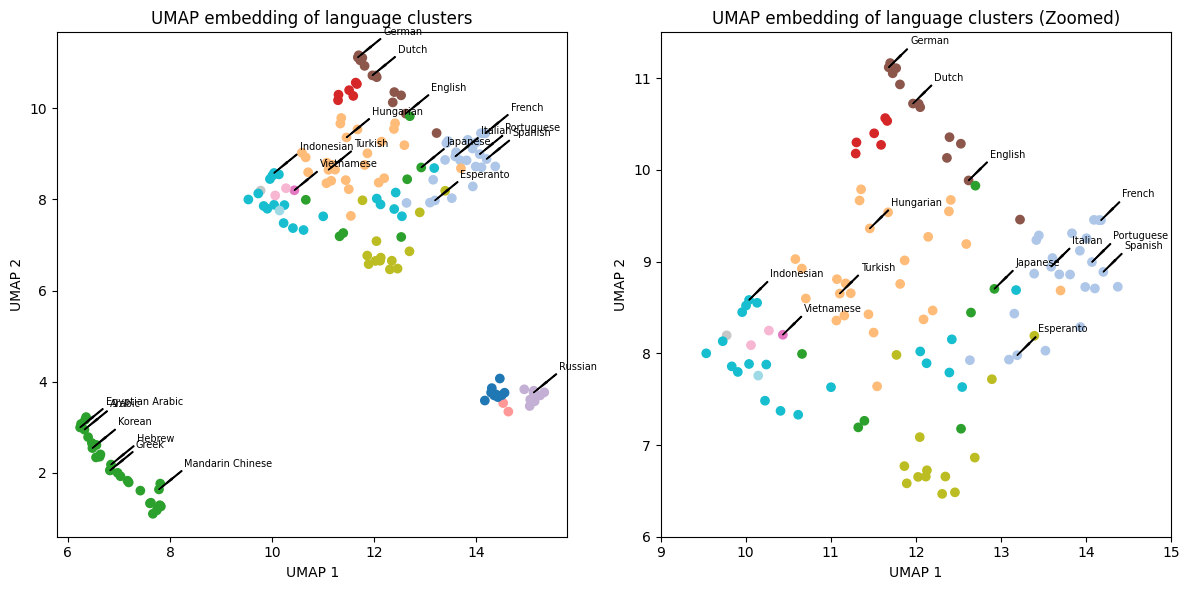

In [90]:
# load umap embedding
umap_embedding = np.load('data/tatoeba/umap_embedding.npy')

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Unzoomed UMAP plot
ax[0].scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=cluster_labels, cmap='tab20')
ax[0].set_title('UMAP embedding of language clusters')
ax[0].set_xlabel('UMAP 1')
ax[0].set_ylabel('UMAP 2')
# Annotate the first 20 languages with lines
for i in range(20):
    ax[0].annotate(language_labels.iloc[i], 
                 xy=(umap_embedding[i, 0], umap_embedding[i, 1]), 
                 xytext=(umap_embedding[i, 0] + 0.5, umap_embedding[i, 1] + 0.5),
                 arrowprops=dict(facecolor='black', width=0.5, headwidth=1),
                 fontsize=7)
    ax[1].annotate(language_labels.iloc[i], 
                 xy=(umap_embedding[i, 0], umap_embedding[i, 1]), 
                 xytext=(umap_embedding[i, 0] + 0.25, umap_embedding[i, 1] + 0.25),
                 arrowprops=dict(facecolor='black', width=0.5, headwidth=1),
                 fontsize=7)


# Zoomed UMAP plot
zoom_region = [9, 15, 6, 11.5]  # [xmin, xmax, ymin, ymax] 
ax[1].scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=cluster_labels, cmap='tab20')
ax[1].set_xlim(zoom_region[0], zoom_region[1])
ax[1].set_ylim(zoom_region[2], zoom_region[3])
ax[1].set_title('UMAP embedding of language clusters (Zoomed)')
ax[1].set_xlabel('UMAP 1')
ax[1].set_ylabel('UMAP 2')

plt.tight_layout()
plt.show()

plt.show()

In [94]:
# print each cluster and the languages in it
for cluster in range(n_clusters):
    languages_in_cluster = language_labels[cluster_labels == cluster]
    print(f"{languages_in_cluster.to_list()}")
    
# later decided to save this to a markdown file. Not the cleanest but the output was basically already in the format I wanted
clusters = [
    ['Tatar', 'Kazakh', 'Ossetian', 'Kalmyk', 'Chuvash', 'Udmurt', 'Kyrgyz', 'Chukchi', 'Bashkir'],
    ['French', 'Spanish', 'Italian', 'Esperanto', 'Portuguese', 'Latin', 'Romanian', 'Latvian', 'Catalan', 'Middle French', 'Galician', 'Lojban', 'Interlingua', 'Romansh', 'Ido', 'Asturian', 'Occitan', 'Interlingue', 'Novial', 'Ladin', 'Piedmontese', 'Ladino', 'Chavacano', 'Picard'],
    ['Turkish', 'Hungarian', 'Breton', 'Uzbek', 'Quenya', 'Basque', 'Irish', 'Klingon', 'Scottish Gaelic', 'Ottoman Turkish', 'Unknown', 'Sindarin', 'Azerbaijani', 'Turkmen', 'Northern Sami', 'Welsh', 'Northern Kurdish (Kurmancî)', 'Kabyle', 'Berber', 'Haitian Creole', 'Cornish', 'Nahuatl', 'Kotava', 'Seychellois Creole', 'Navajo'],
    ['Mandarin Chinese', 'Japanese', 'Korean', 'Hebrew', 'Greek', 'Arabic', 'Egyptian Arabic', 'Cantonese', 'Shanghainese', 'Georgian', 'Urdu', 'Sanskrit', 'Yiddish', 'Uyghur', 'Persian', 'Iraqi Arabic', 'Armenian', 'Hindi', 'Bengali', 'Thai', 'Literary Chinese', 'Malayalam', 'Telugu', 'Khmer', 'Tibetan', 'Punjabi (Western)', 'Ancient Greek', 'Lao', 'Nepali', 'Marathi', 'Gujarati', 'Punjabi (Eastern)', 'Sumerian', 'Cherokee', 'Algerian Arabic', 'Tamil'],
    ['Swedish', 'Norwegian Nynorsk', 'Norwegian Bokmål', 'Icelandic', 'Faroese', 'Danish'],
    ['Mongolian', 'Tajik'],
    ['Russian', 'Bulgarian', 'Ukrainian', 'Belarusian', 'Serbian', 'Old East Slavic', 'Macedonian', 'Erzya', 'Abkhaz'],
    ['German', 'English', 'Dutch', 'Frisian', 'Afrikaans', 'CycL', 'Low German (Low Saxon)', 'Luxembourgish', 'Scots', 'Old English', 'Kölsch', 'Middle English', 'Swiss German'],
    ['Vietnamese'],
    ['Tagalog', 'Hiligaynon'],
    ['Quechua'],
    ['Czech', 'Polish', 'Albanian', 'Slovak', 'Bosnian', 'Croatian', 'Slovenian', 'Volapük', 'Maltese', 'Upper Sorbian', 'Lower Sorbian', 'Ewe', 'Romani'],
    ['Indonesian', 'Finnish', 'Swahili', 'Malay', 'Estonian', 'Lithuanian', 'Chamorro', 'Sicilian', 'Ainu', 'Toki Pona', 'Javanese', 'Tok Pisin', 'Maori', 'Old Tupi', 'Guarani', 'Malagasy', 'Xhosa', 'Old Prussian', 'Malay (Vernacular)', 'Lakota'],
    ['Lingala']
]

def clusters_to_markdown(clusters):
    # Start with the header row
    markdown_table = "| Cluster | Languages |\n|---|---|\n"
    
    # Add each cluster's information as a new row
    for cluster_id, languages in enumerate(clusters):
        # Join the languages into a comma-separated string
        languages_str = ', '.join(languages)
        # Add the row to the table
        markdown_table += f"| {cluster_id} | {languages_str} |\n"
    
    return markdown_table

clusters_md = clusters_to_markdown(clusters)
print(clusters_md)

['Tatar', 'Kazakh', 'Ossetian', 'Kalmyk', 'Chuvash', 'Udmurt', 'Kyrgyz', 'Chukchi', 'Bashkir']
['French', 'Spanish', 'Italian', 'Esperanto', 'Portuguese', 'Latin', 'Romanian', 'Latvian', 'Catalan', 'Middle French', 'Galician', 'Lojban', 'Interlingua', 'Romansh', 'Ido', 'Asturian', 'Occitan', 'Interlingue', 'Novial', 'Ladin', 'Piedmontese', 'Ladino', 'Chavacano', 'Picard']
['Turkish', 'Hungarian', 'Breton', 'Uzbek', 'Quenya', 'Basque', 'Irish', 'Klingon', 'Scottish Gaelic', 'Ottoman Turkish', 'Unknown', 'Sindarin', 'Azerbaijani', 'Turkmen', 'Northern Sami', 'Welsh', 'Northern Kurdish (Kurmancî)', 'Kabyle', 'Berber', 'Haitian Creole', 'Cornish', 'Nahuatl', 'Kotava', 'Seychellois Creole', 'Navajo']
['Mandarin Chinese', 'Japanese', 'Korean', 'Hebrew', 'Greek', 'Arabic', 'Egyptian Arabic', 'Cantonese', 'Shanghainese', 'Georgian', 'Urdu', 'Sanskrit', 'Yiddish', 'Uyghur', 'Persian', 'Iraqi Arabic', 'Armenian', 'Hindi', 'Bengali', 'Thai', 'Literary Chinese', 'Malayalam', 'Telugu', 'Khmer', 'Ti

In [91]:
print(language_matrix[:5])

[[3.77518623e-05 9.28814151e-06 2.90117466e-07 ... 1.79954925e-08
  0.00000000e+00 5.73261695e-08]
 [2.24854851e-02 1.24721761e-05 5.35421970e-03 ... 0.00000000e+00
  0.00000000e+00 1.53395463e-07]
 [6.71036685e-06 1.81954426e-06 9.30923480e-07 ... 3.05341969e-02
  2.68347085e-02 7.44721425e-02]
 [2.86608161e-02 1.09162908e-02 1.09357619e-03 ... 0.00000000e+00
  0.00000000e+00 1.08531138e-07]
 [3.91375570e-02 1.86568956e-02 4.84066372e-03 ... 2.18656314e-07
  2.09536038e-07 3.77512908e-07]]
